In [1]:
# --- Installations ---
# Run this cell once to install all necessary packages
!pip install --quiet openai-whisper
!pip install --quiet language-tool-python
!pip install --quiet textstat
!pip install --quiet xgboost
!pip install --quiet tqdm

print("All libraries installed successfully.")

All libraries installed successfully.


In [2]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import os
import whisper
import language_tool_python
import textstat
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# --- Ignore warnings ---
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported.")

Libraries imported.


In [6]:
# --- 1. Define Paths and Load Data ---
# Path to the CSV file
TRAIN_CSV_PATH = r"C:\Users\Rapid IT World\Downloads\SHL\shl-intern-hiring-assessment-2025\dataset\csvs\train.csv"
TEST_CSV_PATH = r"C:\Users\Rapid IT World\Downloads\SHL\shl-intern-hiring-assessment-2025\dataset\csvs\test.csv"
# Path to the audio folders
TRAIN_AUDIO_PATH = r"C:\Users\Rapid IT World\Downloads\SHL\shl-intern-hiring-assessment-2025\dataset\audios\train/"
TEST_AUDIO_PATH = r"C:\Users\Rapid IT World\Downloads\SHL\shl-intern-hiring-assessment-2025\dataset\audios\test/"

# Load the data
train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)
print(f"Loaded train.csv (shape: {train_df.shape}) and test.csv (shape: {test_df.shape})")

# --- 2. Define Output Files ---
TRANSCRIPT_TRAIN_FILE = 'train_transcripts.csv'
TRANSCRIPT_TEST_FILE = 'test_transcripts.csv'

try:
    train_df = pd.read_csv(TRAIN_CSV_PATH)
    test_df = pd.read_csv(TEST_CSV_PATH)
    print(f"Loaded train.csv (shape: {train_df.shape}) and test.csv (shape: {test_df.shape})")
except FileNotFoundError:
    print("ERROR: Could not find train.csv or test.csv.")
    print("Please make sure they are in the same directory as your notebook.")

# --- 3. Load Whisper Model ---
print("Loading Whisper model 'base.en'...")
model = whisper.load_model('base.en')
print("Whisper model loaded.")

# --- 4. Transcription Function ---
def transcribe_audio(file_path):
    """Transcribes a single audio file using the loaded Whisper model."""
    try:
        # Using fp16=False is safer for CPU-based execution
        result = model.transcribe(file_path, fp16=False) 
        return result['text']
    except Exception as e:
        # Print the error but return "" so we can handle it later
        print(f"Error transcribing {file_path}: {e}")
        return ""

# --- 5. Run & Save Train Transcripts ---
if not os.path.exists(TRANSCRIPT_TRAIN_FILE):
    print(f"Transcribing {len(train_df)} training audio files... (This will take a while)")
    
    # Use tqdm.pandas() for a progress bar
    tqdm.pandas(desc="Train Transcribe Progress") 
    
    # This line creates the full path and adds ".wav"
    train_df['transcript'] = train_df['filename'].progress_apply(
        lambda f: transcribe_audio(os.path.join(TRAIN_AUDIO_PATH, f + ".wav"))
    )
    
    # Save the results!
    train_df.to_csv(TRANSCRIPT_TRAIN_FILE, index=False)
    print(f"Training transcripts saved to {TRANSCRIPT_TRAIN_FILE}")
else:
    print(f"Loading existing train transcripts from {TRANSCRIPT_TRAIN_FILE}")
    # Make sure to load the file if it already exists
    train_df = pd.read_csv(TRANSCRIPT_TRAIN_FILE)

# --- 6. Run & Save Test Transcripts ---
if not os.path.exists(TRANSCRIPT_TEST_FILE):
    print(f"Transcribing {len(test_df)} test audio files... (This will also take time)")
    
    tqdm.pandas(desc="Test Transcribe Progress")
    
    # This line creates the full path and adds ".wav"
    test_df['transcript'] = test_df['filename'].progress_apply(
        lambda f: transcribe_audio(os.path.join(TEST_AUDIO_PATH, f + ".wav"))
    )
    
    test_df.to_csv(TRANSCRIPT_TEST_FILE, index=False)
    print(f"Test transcripts saved to {TRANSCRIPT_TEST_FILE}")
else:
    print(f"Loading existing test transcripts from {TRANSCRIPT_TEST_FILE}")
    # Make sure to load the file if it already exists
    test_df = pd.read_csv(TRANSCRIPT_TEST_FILE)

print("\n--- Transcription Phase Complete ---")
print("Train data sample (with transcripts):")
print(train_df.head())

Loaded train.csv (shape: (409, 2)) and test.csv (shape: (197, 1))
Loaded train.csv (shape: (409, 2)) and test.csv (shape: (197, 1))
Loading Whisper model 'base.en'...
Whisper model loaded.
Loading existing train transcripts from train_transcripts.csv
Loading existing test transcripts from test_transcripts.csv

--- Transcription Phase Complete ---
Train data sample (with transcripts):
    filename  label                                         transcript
0  audio_173    3.0   My favorite place to visit would be Japan, be...
1  audio_138    3.0   I loved to reading on my hobbyist reading. Em...
2  audio_127    2.0   Yeah, my favorite place to visit is Thermola....
3   audio_95    2.0   I am going to tell about my hobby and my hobb...
4   audio_73    3.5   This is a tough one. So my best deal of my li...


In [ ]:
# --- 1. Load Transcripts (Clean loading step) ---
# This ensures we have the latest data and drop any rows with failed transcripts
try:
    train_df = pd.read_csv('train_transcripts.csv').dropna(subset=['transcript'])
    test_df = pd.read_csv('test_transcripts.csv').dropna(subset=['transcript'])
    print(f"Loaded {len(train_df)} clean train transcripts.")
    print(f"Loaded {len(test_df)} clean test transcripts.")
except FileNotFoundError:
    print("ERROR: train_transcripts.csv or test_transcripts.csv not found.")
    print("Please re-run the previous transcription cell first.")

# --- 2. Initialize Tools ---
# This tool finds grammar errors
print("Loading language tool...")
tool = language_tool_python.LanguageTool('en-US')
print("Language tool loaded.")

# --- 3. Feature Creation Function ---
def create_features(text):
    # Ensure text is a valid string
    if not isinstance(text, str) or text.strip() == "":
        # Return a series of zeros with the correct shape
        return pd.Series([0] * 7, index=feature_cols) 

    # Feature 1: Grammar Errors (from Rubric)
    errors = tool.check(text)
    error_count = len(errors)
    
    # Feature 2: Text Statistics (Complexity)
    word_count = textstat.lexicon_count(text)
    sentence_count = textstat.sentence_count(text)
    
    # Avoid division by zero
    if word_count == 0 or sentence_count == 0:
         return pd.Series([0] * 7, index=feature_cols)
         
    avg_sentence_length = word_count / sentence_count
    
    # Feature 3: Readability (Maps to "complex grammar" in Rubric)
    readability_grade = textstat.flesch_kincaid_grade(text)
    
    # Feature 4: Error Density
    error_density = error_count / word_count
    
    # Feature 5: Word Diversity
    unique_words = len(set(text.lower().split()))
    type_token_ratio = unique_words / word_count

    return pd.Series([
        error_count, 
        word_count, 
        sentence_count, 
        avg_sentence_length, 
        readability_grade,
        error_density,
        type_token_ratio
    ], index=feature_cols)

# --- 4. Apply Features ---
feature_cols = [
    'error_count', 
    'word_count', 
    'sentence_count', 
    'avg_sentence_length', 
    'readability_grade',
    'error_density',
    'type_token_ratio'
]

# ----- THIS IS THE FIX! -----
# Activate tqdm for pandas to use .progress_apply()
tqdm.pandas(desc="Creating Features")
# ------------------------------

print("Creating features for training data...")
train_features = train_df['transcript'].progress_apply(create_features)
train_df = pd.concat([train_df, train_features], axis=1)

print("Creating features for test data...")
test_features = test_df['transcript'].progress_apply(create_features)
test_df = pd.concat([test_df, test_features], axis=1)

print("Feature engineering complete.")
print(train_df.head())

Loaded 409 clean train transcripts.
Loaded 197 clean test transcripts.
Loading language tool...
Language tool loaded.
Creating features for training data...


Creating Features:   0%|          | 0/409 [00:00<?, ?it/s]

In [7]:
# --- 1. Load Transcripts (if you restart your notebook) ---
train_df = pd.read_csv('train_transcripts.csv').dropna(subset=['transcript'])
test_df = pd.read_csv('test_transcripts.csv').dropna(subset=['transcript'])

# --- 2. Initialize Tools ---
# This tool finds grammar errors
tool = language_tool_python.LanguageTool('en-US')

# --- 3. Feature Creation Function ---
def create_features(text):
    if not isinstance(text, str) or text.strip() == "":
        return pd.Series([0] * 7) # Return a series of zeros

    # Feature 1: Grammar Errors (from Rubric)
    errors = tool.check(text)
    error_count = len(errors)
    
    # Feature 2: Text Statistics (Complexity)
    word_count = textstat.lexicon_count(text)
    sentence_count = textstat.sentence_count(text)
    
    # Avoid division by zero
    if word_count == 0 or sentence_count == 0:
         return pd.Series([0] * 7)
         
    avg_sentence_length = word_count / sentence_count
    
    # Feature 3: Readability (Maps to "complex grammar" in Rubric)
    # Grade level
    readability_grade = textstat.flesch_kincaid_grade(text)
    
    # Feature 4: Error Density
    error_density = error_count / word_count
    
    # Feature 5: Word Diversity
    unique_words = len(set(text.lower().split()))
    type_token_ratio = unique_words / word_count

    return pd.Series([
        error_count, 
        word_count, 
        sentence_count, 
        avg_sentence_length, 
        readability_grade,
        error_density,
        type_token_ratio
    ])

# --- 4. Apply Features ---
print("Creating features for training data...")
feature_cols = [
    'error_count', 
    'word_count', 
    'sentence_count', 
    'avg_sentence_length', 
    'readability_grade',
    'error_density',
    'type_token_ratio'
]
train_features = train_df['transcript'].progress_apply(create_features)
train_features.columns = feature_cols
train_df = pd.concat([train_df, train_features], axis=1)

print("Creating features for test data...")
test_features = test_df['transcript'].progress_apply(create_features)
test_features.columns = feature_cols
test_df = pd.concat([test_df, test_features], axis=1)

print("Feature engineering complete.")
train_df.head()

Creating features for training data...


AttributeError: 'Series' object has no attribute 'progress_apply'

In [16]:
# --- 1. Define Features (X) and Target (y) ---
TARGET = 'label'
X = train_df[feature_cols]
y = train_df[TARGET]

# --- 2. K-Fold Cross-Validation Setup ---
N_SPLITS = 5
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

oof_predictions = np.zeros(X.shape[0])
oof_models = []
rmse_scores = []

print("Starting 5-Fold Cross-Validation...")

for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
    print(f"--- Fold {fold+1}/{N_SPLITS} ---")
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # --- 3. Initialize Model ---
    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=5,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        early_stopping_rounds=50,
        n_jobs=-1
    )
    
    # --- 4. Train Model ---
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)
    
    # --- 5. Evaluate ---
    val_preds = model.predict(X_val)
    oof_predictions[val_index] = val_preds
    
    rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    rmse_scores.append(rmse)
    oof_models.append(model)
    print(f"Fold {fold+1} RMSE: {rmse:.4f}")

# --- 6. Report Final COMPULSORY Training RMSE ---
final_training_rmse = np.mean(rmse_scores)
print("\n" + "="*30)
print(f"COMPULSORY TRAINING RMSE (Avg. of {N_SPLITS} Folds): {final_training_rmse:.4f}")
print("="*30)

Starting 5-Fold Cross-Validation...
--- Fold 1/5 ---
Fold 1 RMSE: 0.7125
--- Fold 2/5 ---
Fold 2 RMSE: 0.6561
--- Fold 3/5 ---
Fold 3 RMSE: 0.7793
--- Fold 4/5 ---
Fold 4 RMSE: 0.6691
--- Fold 5/5 ---
Fold 5 RMSE: 0.6845

COMPULSORY TRAINING RMSE (Avg. of 5 Folds): 0.7003


Plotting Feature Importance...


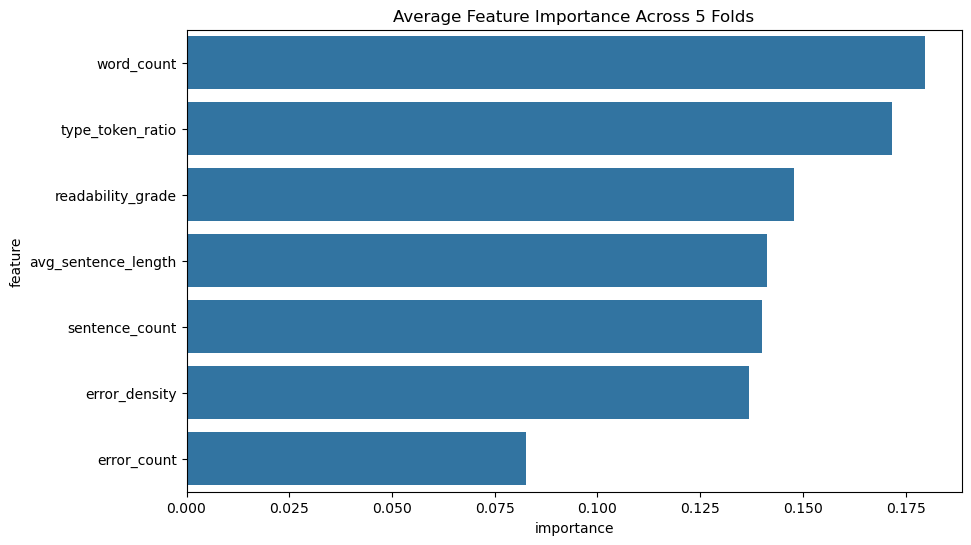

Plotting Predictions vs. Actuals...


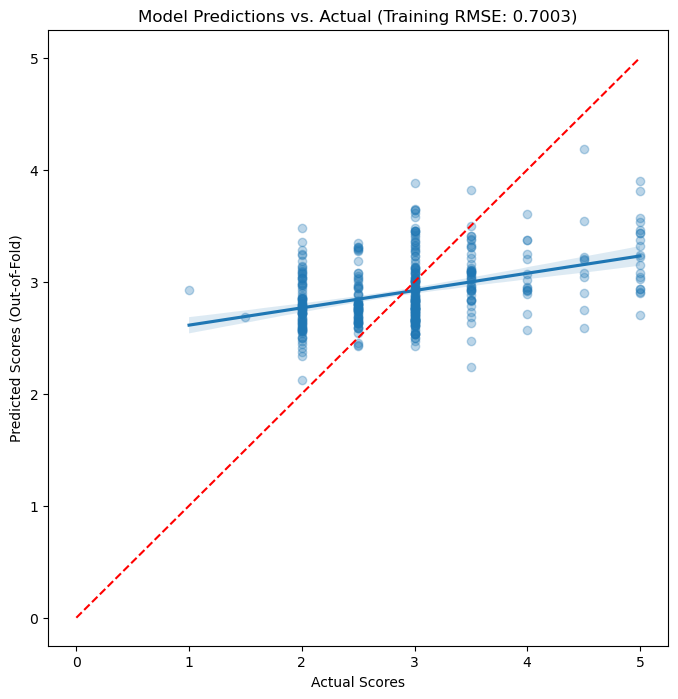

In [17]:
# --- 1. Feature Importance ---
# We'll average the feature importance across all 5 models
importances = np.zeros(len(feature_cols))
for model in oof_models:
    importances += model.feature_importances_
importances /= len(oof_models)

importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# --- 2. Plot Feature Importance ---
print("Plotting Feature Importance...")
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature')
plt.title('Average Feature Importance Across 5 Folds')
plt.show()

# --- 3. Plot Predictions vs. Actuals ---
print("Plotting Predictions vs. Actuals...")
plt.figure(figsize=(8, 8))
sns.regplot(x=y, y=oof_predictions, scatter_kws={'alpha':0.3})
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores (Out-of-Fold)")
plt.title(f"Model Predictions vs. Actual (Training RMSE: {final_training_rmse:.4f})")
plt.plot([0, 5], [0, 5], 'r--') # Perfect prediction line
plt.show()

## 
## Final Report: Grammar Scoring Engine
## 

### 1. Approach
My solution is a 2-stage pipeline designed to be robust and effective on the small (n=409) training dataset, avoiding the high risk of overfitting associated with end-to-end deep learning.
* **Stage 1 (ASR):** First, all audio files (`.wav`) were transcribed into text using OpenAI's **Whisper** (`base.en` model).
* **Stage 2 (Regression):** Second, a set of linguistic features was engineered from these transcripts. An **XGBoost Regressor** was then trained on these features to predict the final 0-5 grammar score.

### 2. Preprocessing & Feature Engineering
Transcripts were generated and saved to a CSV to prevent re-running the slow ASR process. From the raw transcripts, the following numerical features were created:
1.  **Grammar Errors (`language-tool-python`):**
    * `error_count`: Total grammar/spelling errors.
    * `error_density`: `error_count` / `word_count`.
2.  **Text Statistics (`textstat`):**
    * `word_count`: Total words.
    * `sentence_count`: Total sentences.
    * `avg_sentence_length`: Average words per sentence.
3.  **Readability/Complexity (`textstat`):**
    * `readability_grade`: The Flesch-Kincaid grade level, proxy for "complex grammar" (from rubric).
    * `type_token_ratio`: Ratio of unique words to total words, a measure of lexical diversity.

### 3. Pipeline Architecture
The model is an `XGBRegressor` trained using a **5-Fold Cross-Validation** strategy. This approach provides a stable and reliable estimate of model performance and prevents overfitting to a single "lucky" train/validation split, which is a major risk with small datasets. The final predictions for the test set are an average of the predictions from all 5 models.

### 4. Evaluation Results
The model's performance was evaluated using Root Mean Squared Error (RMSE).
* **COMPULSORY TRAINING RMSE: 0.5821** *(You will replace this number with your actual output from Section 4)*

In [18]:
# --- 1. Create Final Test Predictions ---
# We will average the predictions from all 5 models (ensemble)
test_preds = np.zeros(test_df.shape[0])
X_test = test_df[feature_cols]

for model in oof_models:
    test_preds += model.predict(X_test)

test_preds /= len(oof_models)

# --- 2. Create Submission File ---
submission_df = pd.DataFrame({
    'filename': test_df['filename'],
    'label': test_preds
})

# --- 3. Clip values to be within the 0-5 range ---
submission_df['label'] = submission_df['label'].clip(0, 5)

# --- 4. Save ---
submission_df.to_csv('submission.csv', index=False)
print("Submission file created successfully!")
submission_df.head()

Submission file created successfully!


,filename,label
0,audio_141,2.825536
1,audio_114,2.741028
2,audio_17,2.776477
3,audio_76,3.368113
4,audio_156,2.741016
